<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#SQL-WORKSHOP" data-toc-modified-id="SQL-WORKSHOP-1">SQL WORKSHOP</a></span></li><li><span><a href="#Q1" data-toc-modified-id="Q1-2">Q1</a></span></li><li><span><a href="#Q2" data-toc-modified-id="Q2-3">Q2</a></span></li><li><span><a href="#Q3" data-toc-modified-id="Q3-4">Q3</a></span></li><li><span><a href="#Q4" data-toc-modified-id="Q4-5">Q4</a></span></li><li><span><a href="#Q5" data-toc-modified-id="Q5-6">Q5</a></span></li><li><span><a href="#Q6" data-toc-modified-id="Q6-7">Q6</a></span></li><li><span><a href="#Q7" data-toc-modified-id="Q7-8">Q7</a></span></li></ul></div>

# SQL WORKSHOP

<img src="https://s-media-cache-ak0.pinimg.com/originals/d0/b3/18/d0b318cdecf5daaec01357ede40f6d10.jpg">

COVERED TODAY
 * TOP K results
 * SUB QUERIES
 * HAVING CLAUSE
 * UNIQUE PAIRS WITH INNER JOIN
 * INDICES

NOTE: Make sure that you have a column with the duration or number of GPS samples for each trip

In [1]:
# please comment the row below if you don't have the package or install it using 'pip install jupyternotify'
%load_ext jupyternotify

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

DB_FILENAME = '../taxi_trips.db'

<IPython.core.display.Javascript object>

In [2]:
def run_query(query):
    with sqlite3.connect(DB_FILENAME) as con:
        cur = con.cursor()
        cur.execute(query)
        if cur.description is None: 
            return
        col_names = []
        row_values = []
        for col_name in cur.description:
            col_names.append(col_name[0])
        for row in cur.fetchall():
            row_values.append(list(row))
            
        return pd.DataFrame(row_values, columns=col_names)

# Q1
what is the maximum, minimum and average trip lengths?

In [3]:
SQL = "SELECT max((nGPSSamples-1)*15) as max_length, " \
        "min((nGPSSamples-1)*15) as min_length, " \
        "avg((nGPSSamples-1)*15) as avg_length " \
        "FROM trips"
run_query(SQL)

,max_length,min_length,avg_length
0,7200,120,729.091766


# Q2
what is the percentage of trips that took longer than average?

**using only sql**

In [4]:
SQL = "SELECT ROUND(100.0 * (SELECT count(TRIP_ID) FROM trips " \
        " WHERE (nGPSSamples-1)*15 > (SELECT avg(nGPSSamples-1)*15 FROM trips)) " \
        " / count(*),2) || '%' as pct_above_avg FROM trips;"
run_query(SQL)

,pct_above_avg
0,38.14%


# Q3
Find all taxis with more than 6500 trips using the HAVING clause

In [5]:
SQL = "SELECT TAXI_ID, count(*) as n_trips FROM trips GROUP BY TAXI_ID HAVING count(*) > 6500 " \
        "ORDER BY n_trips DESC;"
run_query(SQL)

,TAXI_ID,n_trips
0,20000483,7539
1,20000621,7205
2,20000307,7194
3,20000492,7036
4,20000129,7026
5,20000364,6954
6,20000529,6871
7,20000424,6818
8,20000089,6804
9,20000403,6764


# Q4
Find all unique trip pairs that have the same length
unique means that you cant have trips 1 and 2 and trips 2 and 1 in the same result set. Pairs are invariant to order. 

In [6]:
%%notify -m "Question 4 finished running"
SQL = "SELECT t.TRIP_ID as TRIP_ID_1, t2.TRIP_ID as TRIP_ID_2, (t.nGPSSamples-1)*15 as length_in_sec " \
        "FROM trips t " \
        "JOIN trips t2 ON t.nGPSSamples = t2.nGPSSamples AND t.TRIP_ID < t2.TRIP_ID LIMIT 10;"
run_query(SQL)

,TRIP_ID_1,TRIP_ID_2,length_in_sec
0,1372636858620000589,1372638035620000337,330
1,1372636858620000589,1372641724620000435,330
2,1372636858620000589,1372644655620000520,330
3,1372636858620000589,1372650838620000398,330
4,1372636858620000589,1372651101620000197,330
5,1372636858620000589,1372653190620000279,330
6,1372636858620000589,1372654628620000105,330
7,1372636858620000589,1372656656620000280,330
8,1372636858620000589,1372661016620000435,330
9,1372636858620000589,1372661191620000148,330


<IPython.core.display.Javascript object>

# Q5
What are top 10 rarest and most common trip lengths in minutes in the database? How many of each?

In [21]:
SQL = """SELECT (nGPSSamples-1)*15 / 60.0 as length_in_min, count(TRIP_ID) n_trips FROM trips
        GROUP BY 
        (nGPSSamples-1)*15 / 60.0
        ORDER BY
        n_trips
        limit 10"""
run_query(SQL)

,length_in_min,n_trips
0,118.25,6
1,119.50,6
2,109.25,8
3,118.00,8
4,119.25,8
5,108.25,9
6,114.75,9
7,117.00,9
8,101.00,10
9,109.00,10


In [22]:
%%notify -m "Question 5 finished running"
SQL = """SELECT (nGPSSamples-1)*15 / 60.0 as length_in_min, count(TRIP_ID) n_trips FROM trips
        GROUP BY 
        (nGPSSamples-1)*15 / 60.0
        ORDER BY
        n_trips DESC
        limit 10"""
run_query(SQL)

,length_in_min,n_trips
0,8.50,33051
1,8.00,32822
2,8.25,32779
3,7.75,32635
4,7.50,32498
5,9.00,32426
6,8.75,32364
7,9.25,31885
8,9.50,31429
9,7.25,31426


<IPython.core.display.Javascript object>

# Q6 
-- save your notebook

calculate the 2 hours moving average on trip duration **on the first 30 days in the database** (based on start time). Calculate only on full windows. Did it finish ? First try to execute on just a few trips. You should have a row per trip in the results. 

In [9]:
%%notify -m "Question 6 finished running"
# we limited the query to 10 results / 12 hours of db entries to make sure it finishes running
SQL = """SELECT t2.TRIP_ID, avg(t1.nGPSSamples-1)*15 as mm_2h
        FROM trips t1, trips t2
        WHERE 
        t1.TIMESTAMP < t2.TIMESTAMP
        AND t2.TIMESTAMP <= 7200 + t1.TIMESTAMP
        AND t2.TIMESTAMP BETWEEN 
                   (SELECT min(TIMESTAMP) + 7200 FROM trips) 
                       AND (SELECT min(TIMESTAMP) + 60 * 60 * 12 FROM trips)
        GROUP BY t2.TRIP_ID
        LIMIT 10
        """

run_query(SQL)

,TRIP_ID,mm_2h
0,1372644235620000520,582.573529
1,1372644253620000574,580.839416
2,1372644270620000173,591.847826
3,1372644281620000320,588.478261
4,1372644302620000560,590.364964
5,1372644311620000492,588.695652
6,1372644406620000154,589.208633
7,1372644406620000486,589.208633
8,1372644436620000112,594.928058
9,1372644458620000450,594.565217


<IPython.core.display.Javascript object>

In [10]:
SQL = """EXPLAIN QUERY PLAN SELECT t2.ID, avg(t1.nGPSSamples-1)*15 as mm_2h
        FROM trips t1, trips t2
        WHERE 
        t1.TIMESTAMP < t2.TIMESTAMP
        AND t2.TIMESTAMP - t1.TIMESTAMP <= 7200
        AND t2.TIMESTAMP BETWEEN 
                   (SELECT min(TIMESTAMP) + 7200 FROM trips) 
                       AND (SELECT min(TIMESTAMP) + 60 * 60 * 12 FROM trips)
        GROUP BY t2.ID
        """

run_query(SQL)

,selectid,order,from,detail
0,0,0,1,SCAN TABLE trips AS t2
1,0,0,0,EXECUTE SCALAR SUBQUERY 1
2,1,0,0,SEARCH TABLE trips
3,0,0,0,EXECUTE SCALAR SUBQUERY 2
4,2,0,0,SEARCH TABLE trips
5,0,1,0,SCAN TABLE trips AS t1


# Q7 
Create an index over start time and rerun query

In [11]:
# Let's create an index on the LOCALDATETIME column and re-run the query
SQL = "CREATE INDEX idx_trips_TIMESTAMP ON trips(TIMESTAMP);"
run_query(SQL)

In [11]:
SQL = """EXPLAIN QUERY PLAN SELECT t2.TRIP_ID, avg(t1.nGPSSamples-1)*15 as mm_2h
        FROM trips t1, trips t2
        WHERE 
        t1.TIMESTAMP < t2.TIMESTAMP
        AND t2.TIMESTAMP <= 7200 + t1.TIMESTAMP
        AND t2.TIMESTAMP BETWEEN 
                   (SELECT min(TIMESTAMP) + 7200 FROM trips) 
                       AND (SELECT min(TIMESTAMP) + 60 * 60 * 24 * 30 FROM trips)
        GROUP BY t2.TRIP_ID
        """

run_query(SQL)

,selectid,order,from,detail
0,0,0,1,SEARCH TABLE trips AS t2 USING INDEX idx_trips...
1,0,0,0,EXECUTE SCALAR SUBQUERY 1
2,1,0,0,SEARCH TABLE trips USING COVERING INDEX idx_tr...
3,0,0,0,EXECUTE SCALAR SUBQUERY 2
4,2,0,0,SEARCH TABLE trips USING COVERING INDEX idx_tr...
5,0,1,0,SEARCH TABLE trips AS t1 USING INDEX idx_trips...
6,0,0,0,USE TEMP B-TREE FOR GROUP BY


In [12]:
%%notify -m "Question 7 finished running"
SQL = """SELECT t2.TRIP_ID, avg(t1.nGPSSamples-1)*15 as mm_2h
        FROM trips t1, trips t2
        WHERE 
        t1.TIMESTAMP < t2.TIMESTAMP
        AND t2.TIMESTAMP <= t1.TIMESTAMP + 7200
        AND t2.TIMESTAMP BETWEEN 
                   (SELECT min(TIMESTAMP) + 7200 FROM trips) 
                       AND (SELECT min(TIMESTAMP) + 60 * 60 * 24 * 30 FROM trips)
        GROUP BY t2.TRIP_ID
        """

df_q7 = run_query(SQL)
df_q7

,TRIP_ID,mm_2h
0,1372644235620000520,582.573529
1,1372644253620000574,580.839416
2,1372644270620000173,591.847826
3,1372644281620000320,588.478261
4,1372644302620000560,590.364964
5,1372644311620000492,588.695652
6,1372644406620000154,589.208633
7,1372644406620000486,589.208633
8,1372644436620000112,594.928058
9,1372644458620000450,594.565217


<IPython.core.display.Javascript object>

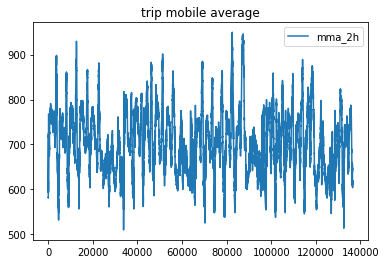

In [22]:
# plotting
f = plt.figure()
plt.plot(df_q7['mm_2h'], '-', label='mma_2h')
plt.legend()
plt.title('trip mobile average')
plt.show()